# Simple power spectrum estimation from an input dataset
This example shows how to estimate the power spectrum from a set of data files using an Optimal Quadratic Estimator (OQE) approach.

In [1]:
%matplotlib inline
import pyuvdata as uv
import hera_pspec as ps
import numpy as np
import pylab as plt

## Loading the input data
The input data are specified as a list of `UVData` objects, which are then packaged into a `PSpecData` class. This class is responsible for collecting the data and covariances together and performing the OQE power spectrum estimation. At least two `UVData` objects must be specified -- power spectra are only ever estimated on independent datafiles, to remove noise bias.

In [2]:
# List of filenames of the data to load
dfiles = [
    'zen.2458042.12552.xx.HH.uvXAA',
    'zen.2458042.12552.xx.HH.uvXAA'
]

# Load into UVData objects
d = []
for dfile in dfiles:
    _d = uv.UVData()
    _d.read_miriad(dfile)
    d.append(_d)

# Set weights (None => flags from UVData will be used)
w = [None for _d in dfiles]

# Check which baseline pairs are available
print(d[0].get_antpairs())

[(24, 24), (24, 25), (24, 38), (25, 25), (25, 38), (38, 38)]


In [3]:
# Create a new PSpecData object
ds = ps.PSpecData(dsets=d, wgts=w)

## Estimating the power spectrum
Estimate the power spectrum for all (non-auto) combinations of datasets in `PSpecData`. You can specify which baselines are included in the power spectrum estimate, and how the estimate should be weigted.

In [4]:
# Specify which baselines to include
bls = [(24,25), (24,38), (25,38)]

# Calculate the power spectrum using an M ~ F^-1/2 weighting
pspec, pairs = ds.pspec(bls, weights='F^-1/2')

In [5]:
# Print the shape of the power spectrum array that was output
print(pspec.shape) # (No. dataset and baseline pairs, No. freqs., No. time bins)

# Print the list of datasets/baselines that went into each power spectrum
for pair in pairs:
    print(pair)

(3, 64, 120)
((0, 24, 25), (1, 24, 25))
((0, 24, 38), (1, 24, 38))
((0, 25, 38), (1, 25, 38))


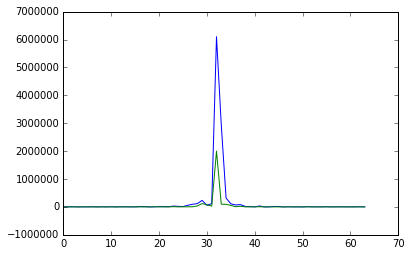

In [6]:
# Plot a few example power spectra
plt.plot(pspec[0,:,0])
plt.plot(pspec[1,:,0])